In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
Base = automap_base()
Base.prepare(engine, reflect = True)
Base.classes.keys()

['measurements', 'stations']

In [5]:
#store tables
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [6]:

# Design a query to retrieve the last 12 months of precipitation data.# Desig 
# Select only the date and prcp values.
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Plot the results using the DataFrame plot method.

In [7]:
#create session
session = Session(engine)

In [8]:
#inspect measurement table

precip_data = session.query(Measurements).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x115bbe668>,
 'date': datetime.date(2010, 1, 1),
 'meas_id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [9]:
from datetime import datetime
most_current = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = most_current[0]
year_before = last_date.replace(year = (last_date.year - 1))
year_before = year_before.strftime("%Y-%m-%d")
year_before

'2016-08-23'

In [10]:
# query for prcp data based on date range from most recent to a year before
twelve_months = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > year_before)

#make data from from sql query

twelve_months_prcp = pd.read_sql_query(twelve_months.statement, engine, index_col = 'date')

In [11]:
#inspect df
twelve_months_prcp.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


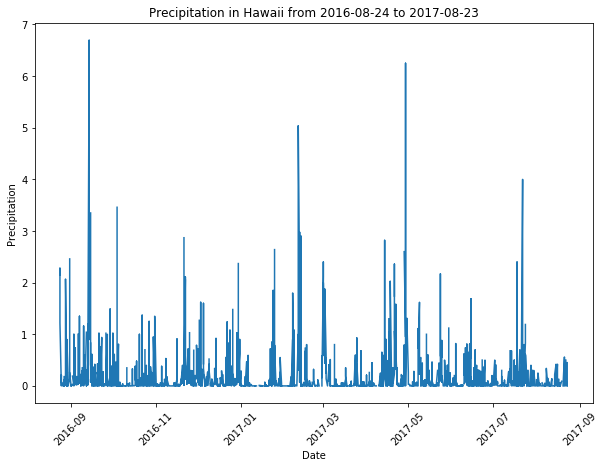

In [12]:
twelve_months_prcp.plot(figsize = (10,7), rot = 45, use_index = True, legend = False)
plt.ylabel('Precipitation')
plt.xlabel('Date')
plt.title('Precipitation in Hawaii from %s to %s' % (twelve_months_prcp.index.min(),twelve_months_prcp.index.max()))
plt.show()




In [13]:
#inspect station data.
station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x115c1a630>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [14]:
# get station count,
from sqlalchemy import func
num_stations = session.query(Stations.station).group_by(Stations.station).count()

In [15]:
num_stations




9

In [16]:
#query tables to get count of daily report, all temp data is complete for each record, so the count
#reflects a count of a station giving temp data, prcp data may or may not have been reported on that date

activity = session.query(Stations.station, Stations.name, Measurements.station, func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()

In [17]:
activity




[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [18]:
# most active station
max_activity = activity[0][0:2]
max_activity




('USC00519281', 'WAIHEE 837.5, HI US')

In [19]:
# the number of reports from the most active station
temps_maxact = session.query(Measurements.station, Measurements.tobs).filter(Measurements.station == max_activity[0], Measurements.date > year_before).all()

In [20]:
len(temps_maxact)



351

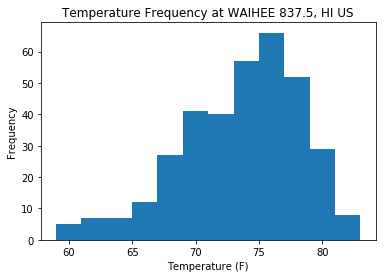

In [21]:
#list created from temperature data query from the most active station

temps = [x[1] for x in temps_maxact]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (max_activity[1]))
plt.show()

In [22]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurements.tobs).filter(Measurements.date >= new_dates[0], Measurements.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()

['2017-07-27', '2017-08-10']


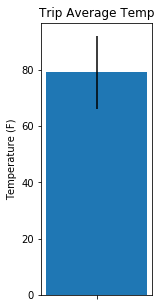

In [23]:
calc_temps('2018-07-27', '2018-08-10')


In [26]:
#query to return list of temps for each date
def daily_normals(chosen_date):
    temps = session.query(Measurements.tobs).filter(Measurements.date.like('%'+chosen_date)).all()
    obs = [x for (x), in temps]
    return obs
    
start_date = '08-23'
end_date = '09-04'

#function to generate list of dates given any start and end date
def create_date_list(start_date, end_date):
    start_month = start_date.split("-")[0]
    end_month = end_date.split("-")[0]
    
    start_day = int(start_date.split("-")[1])
    end_day = int(end_date.split("-")[1])
    
    if start_month == end_month:
        diff = end_day - start_day
        days = [start_day + x for x in range(0,diff + 1) ]
    
    else:
        diff1 = 31 - start_day
        days1 = [start_day + x for x in range(0,diff1 + 1)]
        days2 = [x for x in range(1, end_day + 1)]
        days = days1 + days2
        
    days_str = [('%s-%s' % (start_month, str(x))) if len(str(x)) == 2 else ('%s-0%s' % (end_month, str(x))) for x in days]
    return days_str

#uses functions above to return dictionary of normals, skips dates for which there is no data (false dates)
def query_results(start, end):
    dates = create_date_list(start, end)
    master_dict = {"Date": [], "Max Temp": [], "Min Temp": [], "Average Temp": []}
    for date in dates:
        data_list = []
        observations = daily_normals(date)
        if observations != []:
            for temp in observations:
                data_list.append(temp)
            master_dict['Date'].append(date)
            master_dict['Max Temp'].append(max(data_list))
            master_dict['Min Temp'].append(min(data_list))
            master_dict['Average Temp'].append(round(np.mean(data_list),2))
            master_dict
    return(master_dict)
    
normals_df = pd.DataFrame(query_results('08-01', '08-14')).set_index('Date')
normals_df

,Average Temp,Max Temp,Min Temp
Date,,,
08-01,75.54,83.0,67.0
08-02,75.60,84.0,68.0
08-03,76.61,85.0,70.0
08-04,76.71,84.0,69.0
08-05,76.15,82.0,69.0
08-06,76.25,83.0,67.0
08-07,77.16,83.0,71.0
08-08,76.56,83.0,68.0
08-09,75.98,81.0,69.0


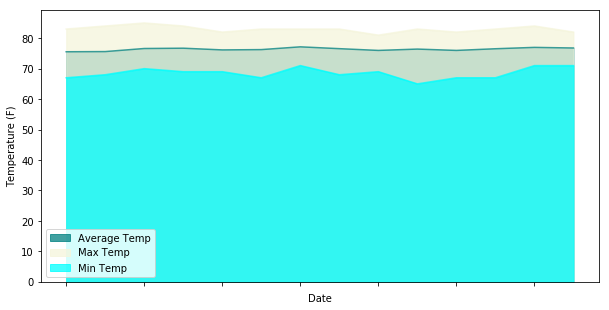

In [29]:

normals_dfnormals_d  = normals_df[['Max Temp', 'Average Temp', 'Min Temp']]

normals_df.plot(kind = 'area', stacked = False, alpha = .75, rot = 45, color = ['teal', 'beige', 'aqua'], figsize = (10,5), linestyle = 'solid')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(frameon = True)
plt.show()